# Benchmarking the M1

author(s): khuynh

This notebook contains the code that plots some of the benchmark data that I collected. I've published all of my benchmark data in this [gist](https://gist.github.com/hkennyv/0f041cb93552d74a5a546ceb585e1bc7).

It includes the following benchmarks:

- cinebench r23 single-core
- cinebench r23 multi-core
- sqlite compile single-job
- sqlite compile multi-job
- advent of code (TODO)

In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
sns.set_theme(style="darkgrid")
sns.set_style("ticks")
plt.style.use("dark_background")

## Cinebench R23

Both a single-core and multi-core benchmark were ran for each device.

In [3]:
# name, y_pos, single_core, multi_core
cinebench_kmac = ["kmac", 0, 1021, 6997]
cinebench_kmba = ["kmba", 1, 1477, 6558]
cinebench_kmbp = ["kmbp", 2, 556, 1385]
idx = np.arange(3)

df_cinebench = pd.DataFrame([cinebench_kmac, cinebench_kmba, cinebench_kmbp], columns=["name", "y_pos", "single_core", "multi_core"])
df_cinebench

,name,y_pos,single_core,multi_core
0,kmac,0,1021,6997
1,kmba,1,1477,6558
2,kmbp,2,556,1385


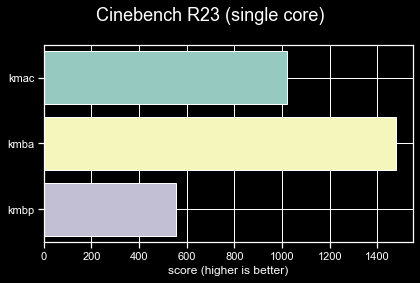

In [4]:
ax = sns.barplot(x="single_core", y="y_pos", data=df_cinebench, orient="h")

ax.set_yticklabels(df_cinebench.name.values)
ax.set_ylabel("")
ax.set_xlabel("score (higher is better)")

plt.suptitle("Cinebench R23 (single core)", fontsize=18)
plt.tight_layout()

plt.grid(True)
plt.savefig("benchmarks-cinebench-sc.png")

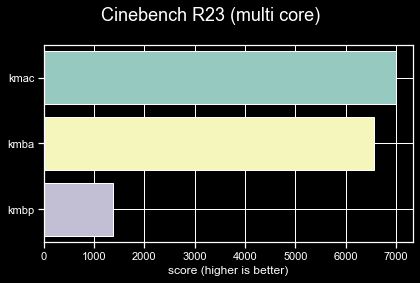

In [5]:
ax = sns.barplot(x="multi_core", y="y_pos", data=df_cinebench, orient="h")

ax.set_yticklabels(df_cinebench.name.values)
ax.set_ylabel("")
ax.set_xlabel("score (higher is better)")

plt.suptitle("Cinebench R23 (multi core)", fontsize=18)
plt.tight_layout()

plt.grid(True)
plt.savefig("benchmarks-cinebench-mc.png")

## Sqlite benchmark

For the sqlite benchmark, I used [hyperfine v1.11.0](https://github.com/sharkdp/hyperfine) to measure the compile times. You can see the raw json data output on github. I did both a single-job and multi-job builds to test both. There is no `nproc` on macos, so the equivalent to get the number of logical cpus is `sysctl -h hw.logicalcpu`. The build commands to do so are shown below:

**single-job**

```
make -j 1
```

**multi-job**

```
make -j $(sysctl -n hw.logicalcpu)
```

And integrating that into hyperfine is a ezpz. **NOTE:** I did use the `--prepare` and `--warmup` options to ensure that the file cache is warm & the build artifacts are removed before running the build command again. I also use the `--export-json` option so that I can have access to the raw data and times. Put that together and we get something that looks like:

```
# single-job
khuynh@kmba:temp/bld $ hyperfine --warmup 3 --prepare 'make clean' 'make -j 1' --export-json kmba-make1.json

# multi-job
khuynh@kmba:temp/bld $ hyperfine --warmup 3 --prepare 'make clean' 'make -j $(sysctl -n hw.logicalcpu)' --export-json kmba-make2.json
```


In [6]:
DATA_DIR = Path("data").resolve()

In [7]:
data = {}

for fp in DATA_DIR.iterdir():
    key = fp.name.strip(".json")
    with fp.open("r") as file:
        data[key] = json.load(file)
    

In [8]:
make1_keys = sorted([key for key in data.keys() if key.endswith("make1")])
make2_keys = sorted([key for key in data.keys() if key.endswith("make2")])

y_pos = np.arange(len(make1_keys)) + 1

make1_means = [data[key]["results"][0]["mean"] for key in make1_keys]
make1_std = [data[key]["results"][0]["stddev"] for key in make1_keys]

make2_means = [data[key]["results"][0]["mean"] for key in make2_keys]
make2_std = [data[key]["results"][0]["stddev"] for key in make2_keys]

df1 = pd.DataFrame({"name": make1_keys, "mean": make1_means, "std": make1_std, "y_pos": y_pos})
df2 = pd.DataFrame({"name": make2_keys, "mean": make2_means, "std": make2_std, "y_pos": y_pos})

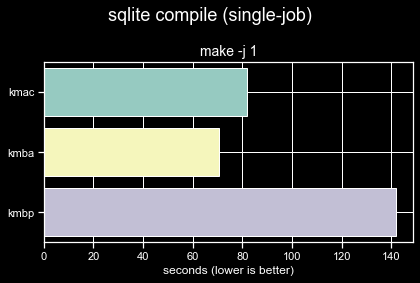

In [9]:
ax = sns.barplot(x="mean", y="y_pos", data=df1, orient="h")

ax.set_yticklabels(df1.name.str.split("-make1").str[0])
ax.set_ylabel("")
ax.set_xlabel("seconds (lower is better)")
ax.set_title(data["kmba-make1"]["results"][0]["command"], fontsize=14)

plt.suptitle("sqlite compile (single-job)", fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.savefig("benchmarks-sqlite-1.png")

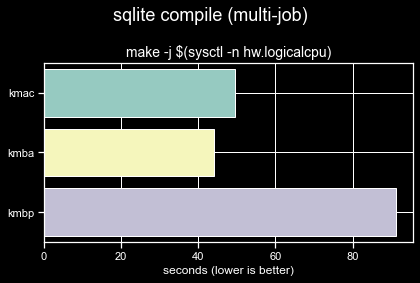

In [10]:
ax = sns.barplot(x="mean", y="y_pos", data=df2, orient="h")

ax.set_yticklabels(df2.name.str.split("-make2").str[0])
ax.set_ylabel("")
ax.set_xlabel("seconds (lower is better)")
ax.set_title(data["kmba-make2"]["results"][0]["command"], fontsize=14)

plt.suptitle("sqlite compile (multi-job)", fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.savefig("benchmarks-sqlite-2.png")